In [1]:
# Project: Energy Consumption Prediction
# Phase 1: Project Setup and Initial Data Exploration

# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style for better aesthetics
# 'fivethirtyeight' is a popular choice for data visualisation
plt.style.use('fivethirtyeight')

# 2. Load the Dataset
try:
    df = pd.read_csv('data/PJME_hourly.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: PJME_hourly.csv not found. Make sure it is in the 'data/' directory.")
    print("Current working directory:", os.getcwd()) # for debugging if there is a path issue

# Display the first few rows
print("\nFirst five rows of the dataset:")
print(df.head())

# Get the earliest and latest date and time in Datetime column
print("\nEarliest date and time:", min(df['Datetime']))
print("Latest date and time:", max(df['Datetime']))

# Get a summary of the DataFrame
print("\nDataFrame Information:")
print(df.info())

# Get descriptive statistics for numerical columns
print("\nDescriptive Statistics:")
print(df.describe())

# 3. Handling Missing Values (if any)
# Check for missing values
print("\nMissing values before processing:")
print(df.isnull().sum())

Dataset loaded successfully.

First five rows of the dataset:
              Datetime  PJME_MW
0  2002-12-31 01:00:00  26498.0
1  2002-12-31 02:00:00  25147.0
2  2002-12-31 03:00:00  24574.0
3  2002-12-31 04:00:00  24393.0
4  2002-12-31 05:00:00  24860.0

Earliest date and time: 2002-01-01 01:00:00
Latest date and time: 2018-08-03 00:00:00

DataFrame Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145366 entries, 0 to 145365
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  145366 non-null  object 
 1   PJME_MW   145366 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.2+ MB
None

Descriptive Statistics:
             PJME_MW
count  145366.000000
mean    32080.222831
std      6464.012166
min     14544.000000
25%     27573.000000
50%     31421.000000
75%     35650.000000
max     62009.000000

Missing values before processing:
Datetime    0
PJME_MW     0
dtype: int64


In [2]:
# 4. Convert 'Datetime' Column to Datetime Object and Set as Index
# Convert 'Datetime' column to datetime objects
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Set 'Datetime' as the DataFrame index and rename it
df = df.set_index('Datetime').rename_axis('Datetime')

# Ensure the index is sorted chronologically
df = df.sort_index()

# Check the new information to confirm datetime index
print("\nDataFrame Information after Datetime conversion and index setting:")
print(df.info())

# Check for any duplicate timestamps
# Should ideally be none for timestamps
print("\nNumber of duplicate timestamps:", df.index.duplicated().sum())

# Check for frequency consistency
# If the data is truly hourly, the difference between consecutive timestamps should be 1 hour
df.index.to_series().diff().value_counts()


DataFrame Information after Datetime conversion and index setting:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145366 entries, 2002-01-01 01:00:00 to 2018-08-03 00:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   PJME_MW  145366 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None

Number of duplicate timestamps: 4


Datetime
0 days 01:00:00    145331
0 days 02:00:00        30
0 days 00:00:00         4
Name: count, dtype: int64

In [3]:
# Handle the 4 duplicate timestamps and the missing hours

print("Original shape:", df.shape)

# Handle duplicate timestamps
# Keep the first occurrence for duplicates
df = df.loc[~df.index.duplicated(keep='first')]
print("Shape after removing duplicate timestamps:", df.shape)

# Create a complete, continuous hourly DateTimeIndex for the entire period
# This fills in any missing hours such as those 2-hour gaps due to Daylight Saving Time transitions
# Find the min and max datetime in the data
start_date = df.index.min()
end_date = df.index.max()

# Generate a complete hourly date range
full_date_range = pd.date_range(start=start_date, end=end_date, freq='h')

# Reindex the DataFrame to this full date range
# This inserts NaN for any missing hours
df = df.reindex(full_date_range)
print("Shape after reindexing to full hourly range:", df.shape)

# Handle missing values introduced by reindexing (due to two-hour gaps)
# Fill in any actual missing hours that are NaN
# For energy consumption, interpolating is often a good choice (especially linear or spline)
print("\nMissing values after reindexing (these are previously 'skipped' hours):")
print(df.isnull().sum())

# Interpolate the missing values
df['PJME_MW'] = df['PJME_MW'].interpolate(method='linear', limit_direction='both', limit_area='inside')

print("\nMissing values after interpolation:")
print(df.isnull().sum())

# Verify the index frequency again (should be perfectly hourly now)
print("\nValue counts of item differences after full processing:")
print(df.index.to_series().diff().value_counts())

Original shape: (145366, 1)
Shape after removing duplicate timestamps: (145362, 1)
Shape after reindexing to full hourly range: (145392, 1)

Missing values after reindexing (these are previously 'skipped' hours):
PJME_MW    30
dtype: int64

Missing values after interpolation:
PJME_MW    0
dtype: int64

Value counts of item differences after full processing:
0 days 01:00:00    145391
Name: count, dtype: int64


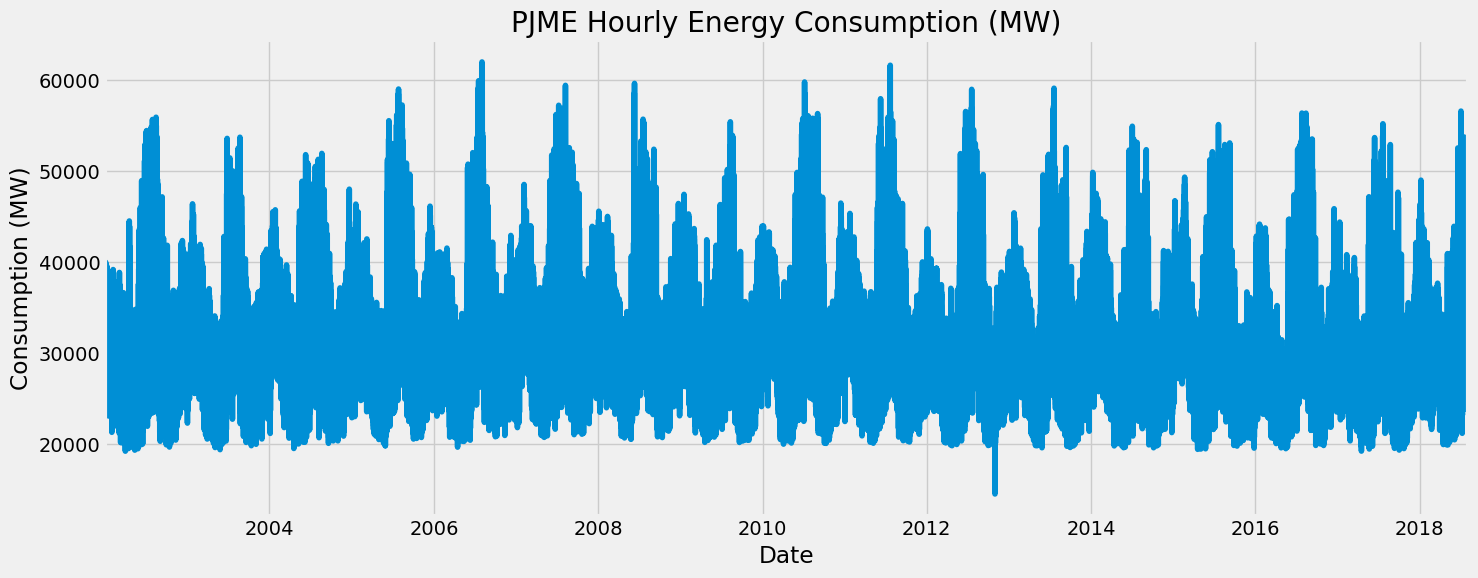

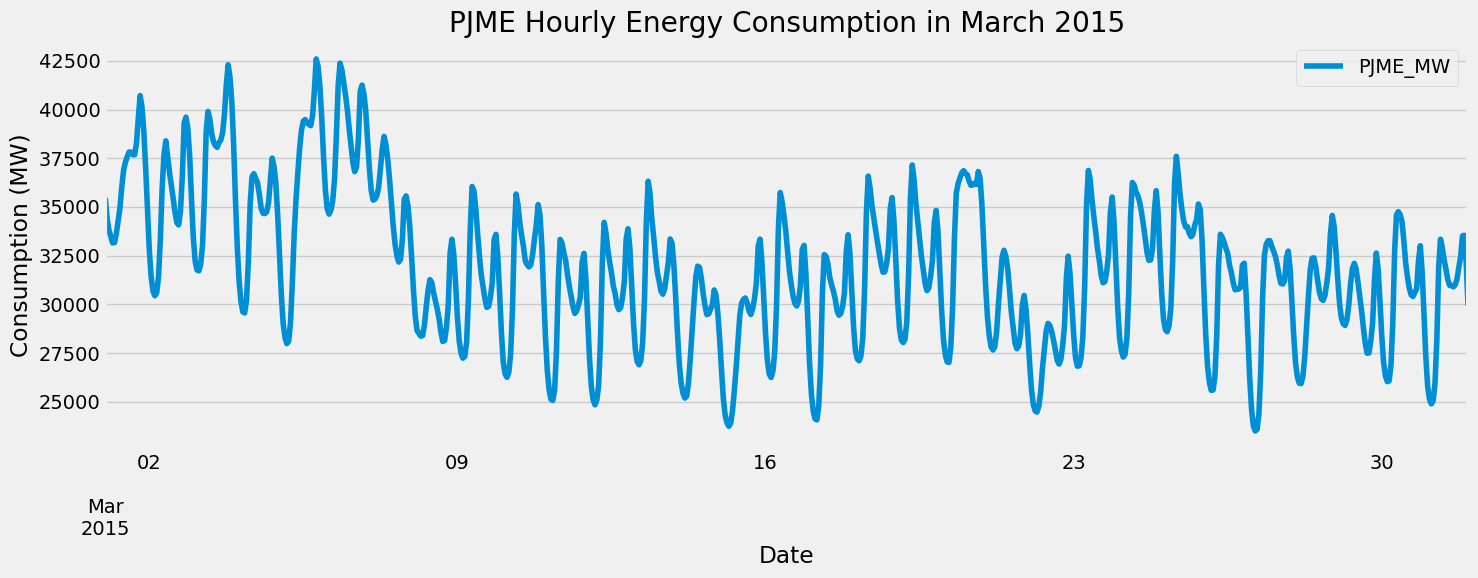

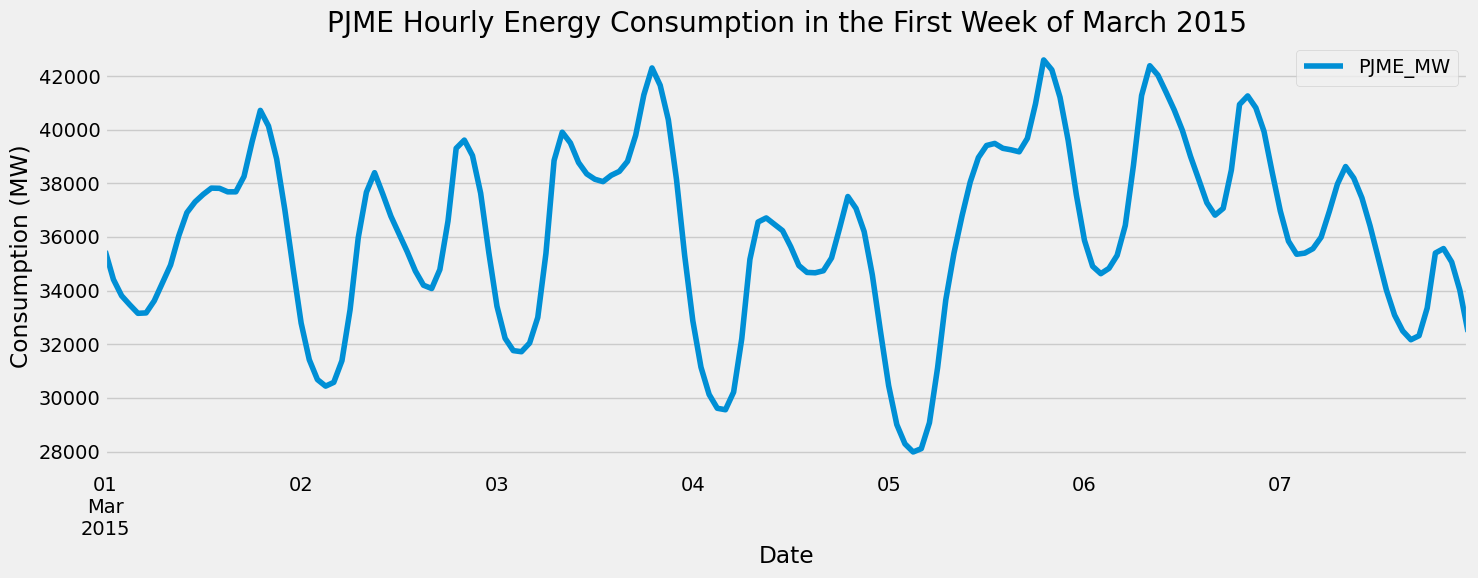

In [4]:
# 5. Initial Visualisations using Exploratory Data Analysis (EDA)
# Plot the entire time series
fig, ax = plt.subplots(figsize=(15, 6))
df['PJME_MW'].plot(ax=ax, title='PJME Hourly Energy Consumption (MW)')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Zoom in on a specific period to see daily/weekly patterns
# Example: May 2015
fig, ax = plt.subplots(figsize=(15, 6))
df.loc['2015-03'].plot(ax=ax, title='PJME Hourly Energy Consumption in March 2015')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Further zoom in: A single week in 2015
fig, ax = plt.subplots(figsize=(15, 6))
df.loc['2015-03-01':'2015-03-07'].plot(ax=ax, title='PJME Hourly Energy Consumption in the First Week of March 2015')
ax.set_xlabel('Date')
ax.set_ylabel('Consumption (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
# Phase 2: Feature Engineering

# 1. Import Additional Library
# Install the 'holidays' library using CLI if it is not done already
# pip install holidays
import holidays

print("Additional feature engineering library imported successfully.")

Additional feature engineering library imported successfully.


In [6]:
# 2.1 Time-Based Features
# These are features that are derived from the existing DatetimeIndex that help the model understand
# hourly, daily, weekly, and annual seasonality.

# Create features based on the datetime index
df['hour_of_day'] = df.index.hour
df['day_of_week'] = df.index.dayofweek # 0 for Monday, 6 for Sunday
df['day_of_year'] = df.index.dayofyear
df['week_of_year'] = df.index.isocalendar().week.astype(int) # using isocalendar for week number
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['year'] = df.index.year
df['is_weekend'] = (df.index.dayofweek >= 5).astype(int) # 1 for weekend (Saturday, Sunday), 0 for weekday
df['day_of_month'] = df.index.day # the day of the month (1-31)

# Create cyclical features for hour, day of year, etc
# These help the models that do not inherently understand cycles (such as linear models)
df['hour_sin'] = np.sin(2 * np.pi * df['hour_of_day'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour_of_day'] / 24)
df['dayofyear_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['dayofyear_cos'] = np.cos(2* np.pi * df['day_of_year'] / 365)

# Re-assert the index column name
df.rename_axis('Datetime', inplace=True)

print("DataFrame after adding time-based features (first 5 rows):")
print(df.head())
print("\nUnique values for a few of the new features:")
print(df['hour_of_day'].unique())
print(df['day_of_week'].unique())
print(df['is_weekend'].value_counts())

DataFrame after adding time-based features (first 5 rows):
                     PJME_MW  hour_of_day  day_of_week  day_of_year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0            1            1            1   
2002-01-01 02:00:00  29265.0            2            1            1   
2002-01-01 03:00:00  28357.0            3            1            1   
2002-01-01 04:00:00  27899.0            4            1            1   
2002-01-01 05:00:00  28057.0            5            1            1   

                     week_of_year  month  quarter  year  is_weekend  \
Datetime                                                              
2002-01-01 01:00:00             1      1        1  2002           0   
2002-01-01 02:00:00             1      1        1  2002           0   
2002-01-01 03:00:00             1      1        1  2002           0   
2002-01-01 04:00:00             1      1        1  2002           0   
2002-01-01 05:00:

In [7]:
# 2.2 Lagged Features
# These features provide information about past energy consumption, which is highly indicative of future consumption.

# Create lagged features
# Consumption from the previous hour
df['lag_1_hour'] = df['PJME_MW'].shift(1)

# Consumption from the same hour on the previous day (24 hours before)
df['lag_24_hour'] = df['PJME_MW'].shift(24)

# Consumption from the same hour on the previous week (168 hours before)
df['lag_168_hour'] = df['PJME_MW'].shift(168)

# There are NaN values at the beginning of these shifted features, which are expected since there is no other data
# to shift from the past. They will need to be handled before modelling by dropping or imputing them carefully.
print("\nDataFrame after adding lagged features (first few rows - will have NaNs):")
print(df.head(200))
print("\nNumber of NaNs in lagged features:")
print(df[['lag_1_hour', 'lag_24_hour', 'lag_168_hour']].isnull().sum())


DataFrame after adding lagged features (first few rows - will have NaNs):
                     PJME_MW  hour_of_day  day_of_week  day_of_year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0            1            1            1   
2002-01-01 02:00:00  29265.0            2            1            1   
2002-01-01 03:00:00  28357.0            3            1            1   
2002-01-01 04:00:00  27899.0            4            1            1   
2002-01-01 05:00:00  28057.0            5            1            1   
...                      ...          ...          ...          ...   
2002-01-09 04:00:00  27759.0            4            2            9   
2002-01-09 05:00:00  28308.0            5            2            9   
2002-01-09 06:00:00  30169.0            6            2            9   
2002-01-09 07:00:00  34261.0            7            2            9   
2002-01-09 08:00:00  36714.0            8            2            9   

 

In [8]:
# 2.3 Public Holidays
# Define the country and states for PJM (mostly US, specific states)
# PJM covers all or parts of DE, IL, IN, KY, MD, MI, NC, NJ, OH, PA, TN, VA, WV, and Washington D.C.
# Start with US federal holidays for simplicity.

# Adjust the years to match the dataset's range of 2002 to 2018
us_holidays = holidays.US(years=range(2002, 2019))

# Create an 'is_holiday' column based on the DataFrame's index dates
# The index only contains the date part for matching with the holidays library
df['date_only'] = df.index.date
df['is_holiday'] = df['date_only'].apply(lambda x: 1 if x in us_holidays else 0)

# Drop the temporary 'date_only' column
df = df.drop(columns=['date_only'])

print("\nDataFrame after adding 'is_holiday' feature (showing a few holiday entries):")
print(df[df['is_holiday'] == 1].head())
print("\nNumber of holidays found:", df['is_holiday'].sum())


DataFrame after adding 'is_holiday' feature (showing a few holiday entries):
                     PJME_MW  hour_of_day  day_of_week  day_of_year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0            1            1            1   
2002-01-01 02:00:00  29265.0            2            1            1   
2002-01-01 03:00:00  28357.0            3            1            1   
2002-01-01 04:00:00  27899.0            4            1            1   
2002-01-01 05:00:00  28057.0            5            1            1   

                     week_of_year  month  quarter  year  is_weekend  \
Datetime                                                              
2002-01-01 01:00:00             1      1        1  2002           0   
2002-01-01 02:00:00             1      1        1  2002           0   
2002-01-01 03:00:00             1      1        1  2002           0   
2002-01-01 04:00:00             1      1        1  2002           0  

In [9]:
# 2.4 Weather Data (Temperature)
# Use historical hourly temperature data for a representative location within the PJM service territory.
# Data is retrieved from Open-Meteo by using their API
# Selected region: Chicago
# Latitude: 41.8832, longitude: -87.6324

# Retrieve historical temperature data from Open-Meteo

import requests

# Define the coordinates for Chicago
latitude = 41.8832
longitude = -87.6324

# Define the date range
start_date = '2002-01-01'
end_date = '2018-08-03'

# Open-Meteo Historical Weather API endpoint
url = "https://archive-api.open-meteo.com/v1/archive"

params = {
    "latitude": latitude,
    "longitude": longitude,
    "start_date": start_date,
    "end_date": end_date,
    "hourly": "temperature_2m", # request hourly temperature at 2 meters
    "timezone": "America/Chicago"
}

response = requests.get(url, params=params)
data = response.json()

# Ensure the energy consumption data has an index name
df.index.name = 'Datetime'

# Check if the API call was successful
if 'hourly' in data:
    temp_df = pd.DataFrame(data['hourly'])
    temp_df['time'] = pd.to_datetime(temp_df['time'])
    temp_df = temp_df.set_index('time')
    temp_df.index.name = 'Datetime'
    temp_df = temp_df.rename(columns={'temperature_2m': 'current_temp'}) # rename column for temperature at 2 meters
    print("Temperature data loaded successfully.")
    print(temp_df.head())
    print(temp_df.info())
else:
    print("Error fetching temperature data:", data)

Temperature data loaded successfully.
                     current_temp
Datetime                         
2002-01-01 00:00:00          -9.2
2002-01-01 01:00:00          -9.5
2002-01-01 02:00:00          -9.9
2002-01-01 03:00:00         -10.0
2002-01-01 04:00:00         -10.2
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145416 entries, 2002-01-01 00:00:00 to 2018-08-03 23:00:00
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   current_temp  145416 non-null  float64
dtypes: float64(1)
memory usage: 2.2 MB
None


In [10]:
# Merge temp_df with the main energy consumption DataFrame (df)
df = df.merge(temp_df[['current_temp']], left_index=True, right_index=True, how='left')
df.rename(columns={'current_temp': 'temperature'}, inplace=True)

print("Merged df (first 5 rows):")
print(df.head())

Merged df (first 5 rows):
                     PJME_MW  hour_of_day  day_of_week  day_of_year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0            1            1            1   
2002-01-01 02:00:00  29265.0            2            1            1   
2002-01-01 03:00:00  28357.0            3            1            1   
2002-01-01 04:00:00  27899.0            4            1            1   
2002-01-01 05:00:00  28057.0            5            1            1   

                     week_of_year  month  quarter  year  is_weekend  \
Datetime                                                              
2002-01-01 01:00:00             1      1        1  2002           0   
2002-01-01 02:00:00             1      1        1  2002           0   
2002-01-01 03:00:00             1      1        1  2002           0   
2002-01-01 04:00:00             1      1        1  2002           0   
2002-01-01 05:00:00             1      1        1 

In [11]:
# Create temperature-derived features

# Lagged temperature feature
df['lag_24_temp'] = df['temperature'].shift(24)

# 3-day rolling average temperature
df['rolling_72_temp_avg'] = df['temperature'].rolling(window=72).mean() # 3-day rolling average

# Squared temperature terms
df['temp_squared'] = np.power(df['temperature'], 2)

# There are NaN values at the beginning of these shifted features, which are expected since there is no other data
# to shift from the past. They will need to be handled before modelling by dropping or imputing them carefully.
print("\nDataFrame after adding temperature-derived features (first few rows - will have NaNs):")
print(df.head(200))
print("\nNumber of NaNs in temperature_derived features:")
print(df[['lag_24_temp', 'rolling_72_temp_avg', 'temp_squared']].isnull().sum())


DataFrame after adding temperature-derived features (first few rows - will have NaNs):
                     PJME_MW  hour_of_day  day_of_week  day_of_year  \
Datetime                                                              
2002-01-01 01:00:00  30393.0            1            1            1   
2002-01-01 02:00:00  29265.0            2            1            1   
2002-01-01 03:00:00  28357.0            3            1            1   
2002-01-01 04:00:00  27899.0            4            1            1   
2002-01-01 05:00:00  28057.0            5            1            1   
...                      ...          ...          ...          ...   
2002-01-09 04:00:00  27759.0            4            2            9   
2002-01-09 05:00:00  28308.0            5            2            9   
2002-01-09 06:00:00  30169.0            6            2            9   
2002-01-09 07:00:00  34261.0            7            2            9   
2002-01-09 08:00:00  36714.0            8            2      

In [12]:
# Drop the NaN values
# Given that the dataset covers years of hourly data from 2002 to 2018, which is over 140,000 hours, the maximum number
# of NaN values is very small in relative to the entire dataset size (0.12%), so it is acceptable to drop the rows with
# NaN values for time series data.

# Create a list of all feature columns that may contain NaN values
feature_columns_to_check = [
    'lag_1_hour', 'lag_24_hour', 'lag_168_hour', 'lag_24_temp', 'rolling_72_temp_avg', 'temp_squared'
]

# Drop rows where any of these specified feature columns have NaN values
df.dropna(subset=feature_columns_to_check, inplace=True)

# Verify that the rows with NaN values are gone
print("Number of NaNs after dropping:")
print(df[feature_columns_to_check].isnull().sum())

Number of NaNs after dropping:
lag_1_hour             0
lag_24_hour            0
lag_168_hour           0
lag_24_temp            0
rolling_72_temp_avg    0
temp_squared           0
dtype: int64


In [13]:
print("Columns in df BEFORE data splitting:")
print(df.columns)

Columns in df BEFORE data splitting:
Index(['PJME_MW', 'hour_of_day', 'day_of_week', 'day_of_year', 'week_of_year',
       'month', 'quarter', 'year', 'is_weekend', 'day_of_month', 'hour_sin',
       'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'lag_1_hour',
       'lag_24_hour', 'lag_168_hour', 'is_holiday', 'temperature',
       'lag_24_temp', 'rolling_72_temp_avg', 'temp_squared'],
      dtype='object')


In [14]:
# Phase 3: Model Selection, Training and Optimisation

# 3.1 Data Splitting
# A chronological split with a cutoff date is the approach adopted to prepare the dataset for model training and
# evaluation. This method is critical for time series data to prevent data leakage, which would otherwise occur with
# random splitting. Data leakage exposes the model to "future information" during training, leading to overly optimistic
# performance estimates on the test set.
# For this project, our choice of cutoff date for the test set is 01 January 2017, which roughly encompasses the last
# 1.5 years of the dataset.

# Define the cutoff date
cutoff_date = '2017-01-01'

# Define the features (X) and target (y)
# The target variable is 'PJME_MW'
target = 'PJME_MW'

# List out all final features excluding the target variable
# Ensure that only the intended features are used and makes the model's inputs very clear for everyone
# Check the list of feature columns: features = [col for col in df.columns if col != target]

features = [
    'hour_of_day', 'day_of_week', 'day_of_year', 'week_of_year', 'month', 'quarter', 'year', 'is_weekend',
    'day_of_month', 'hour_sin', 'hour_cos', 'dayofyear_sin', 'dayofyear_cos', 'lag_1_hour', 'lag_24_hour', 'lag_168_hour',
    'is_holiday', 'temperature', 'lag_24_temp', 'rolling_72_temp_avg', 'temp_squared']

# Split the data chronologically using the explicit feature list
X_train = df[df.index < cutoff_date][features]
y_train = df[df.index < cutoff_date][target]

X_test = df[df.index >= cutoff_date][features]
y_test = df[df.index >= cutoff_date][target]

print(f"Full data shape: {df.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nTrain data range: {X_train.index.min()} to {X_train.index.max()}")
print(f"Test data range: {X_test.index.min()} to {X_test.index.max()}")

# Verify that there is no overlap
if X_train.index.max() < X_test.index.min():
    print("\nData split verified: No temporal overlap between train and test sets.")
else:
    print("\nWarning: Temporal overlap detected. Review your cutoff date or splitting logic.")

Full data shape: (145224, 22)
X_train shape: (131327, 21)
y_train shape: (131327,)
X_test shape: (13897, 21)
y_test shape: (13897,)

Train data range: 2002-01-08 01:00:00 to 2016-12-31 23:00:00
Test data range: 2017-01-01 00:00:00 to 2018-08-03 00:00:00

Data split verified: No temporal overlap between train and test sets.


In [15]:
print("\nColumns in X_test AFTER data splitting:")
print(X_test.columns)


Columns in X_test AFTER data splitting:
Index(['hour_of_day', 'day_of_week', 'day_of_year', 'week_of_year', 'month',
       'quarter', 'year', 'is_weekend', 'day_of_month', 'hour_sin', 'hour_cos',
       'dayofyear_sin', 'dayofyear_cos', 'lag_1_hour', 'lag_24_hour',
       'lag_168_hour', 'is_holiday', 'temperature', 'lag_24_temp',
       'rolling_72_temp_avg', 'temp_squared'],
      dtype='object')


XGBoost Baseline Model Performance:
Root Mean Squared Error (RMSE): 339.45
Mean Absolute Error (MAE): 248.73
R-squared (R^2): 0.9969272384939307


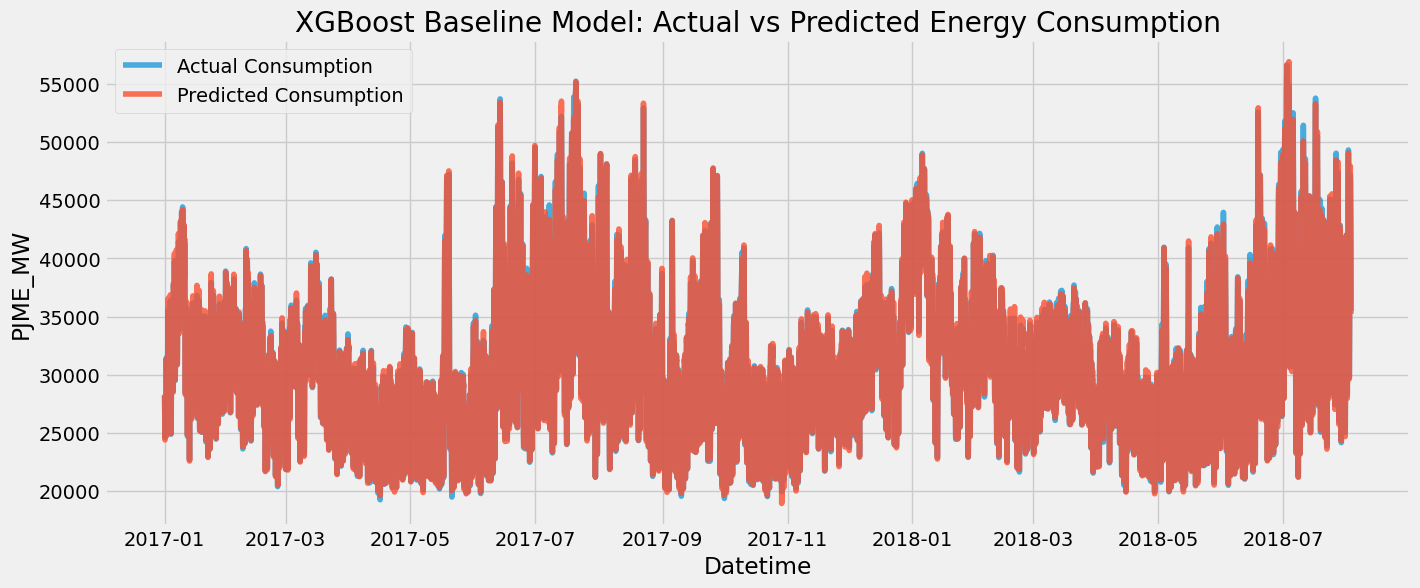

In [16]:
# 3.2 Initial Model Training (for Baseline and Feature Importance)
# Powerful gradient boosting models such as XGBoost and LightGBM are excellent model choices to start with for time
# series forecasting as they can handle complex relationships well and provide feature importance scores.

# Import additional libraries
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- XGBoost Model ---

# Initialise the model
# For initial training, we can use default or slightly adjusted parameters.
# 'n_estimators' is the number of boosting rounds (trees)
# 'early_stopping_rounds' can prevent overfitting during training
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # objective for regression tasks
    n_estimators=1000, # number of boosting rounds (trees)
    learning_rate=0.05, # step size shrinkage to prevent overfitting
    random_state=42, # for reproducibility
    n_jobs=-1, # to use all available CPU cores
    eval_metric='rmse', # evaluate using Root Mean Squared Error
    early_stopping_rounds=50 # to see progress during training
)

# Train the model
# Use eval_set to monitor performance on a validation set
# We will use X_test as a simple validation here but for true tuning, it would be more ideal to use a separate validation
# split from the training data or a time series cross-validation strategy.
# For baseline, using X_test as eval_set is acceptable to see initial performance.
xgb_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
              verbose=False # surpress all printing during training
             )

# Make predictions on the test set
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate the baseline model's performance
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_y_pred))
xgb_mae = mean_absolute_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print(f"XGBoost Baseline Model Performance:")
print(f"Root Mean Squared Error (RMSE): {xgb_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {xgb_mae:.2f}")
print(f"R-squared (R^2): {xgb_r2}")

# Visualise Predictions vs Actuals
# Create a DataFrame for easy plotting
xgb_results = pd.DataFrame({'Actual': y_test, 'Predicted': xgb_y_pred}, index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(xgb_results.index, xgb_results['Actual'], label='Actual Consumption', alpha=0.7)
plt.plot(xgb_results.index, xgb_results['Predicted'], label='Predicted Consumption', alpha=0.8)
plt.title('XGBoost Baseline Model: Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.grid(True)
plt.show()


Top 10 Feature Importances from Baseline XGBoost Model:
                feature  importance
13           lag_1_hour    0.905533
10             hour_cos    0.052553
0           hour_of_day    0.009846
9              hour_sin    0.007402
19  rolling_72_temp_avg    0.004043
1           day_of_week    0.003882
12        dayofyear_cos    0.003802
14          lag_24_hour    0.002408
18          lag_24_temp    0.001814
20         temp_squared    0.001745


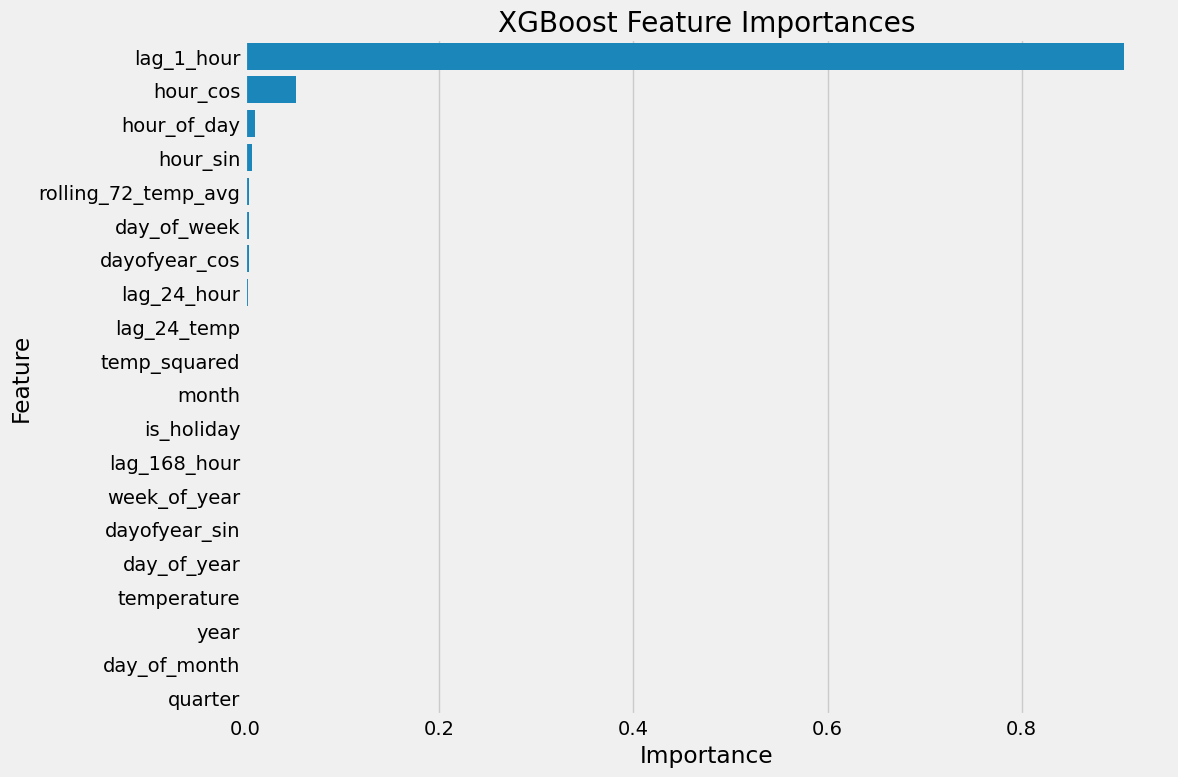

In [17]:
# Extract feature importances
xgb_feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': xgb_model.feature_importances_}
).sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances from Baseline XGBoost Model:")
print(xgb_feature_importances.head(10))

# Visualise all feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=xgb_feature_importances.head(20)) # top 20 features
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2746
[LightGBM] [Info] Number of data points in the train set: 131327, number of used features: 21
[LightGBM] [Info] Start training from score 32185.177043
LightGBM Baseline Model Performance:
Root Mean Squared Error (RMSE): 335.96
Mean Absolute Error (MAE): 248.34
R-squared (R^2): 0.996990114808874


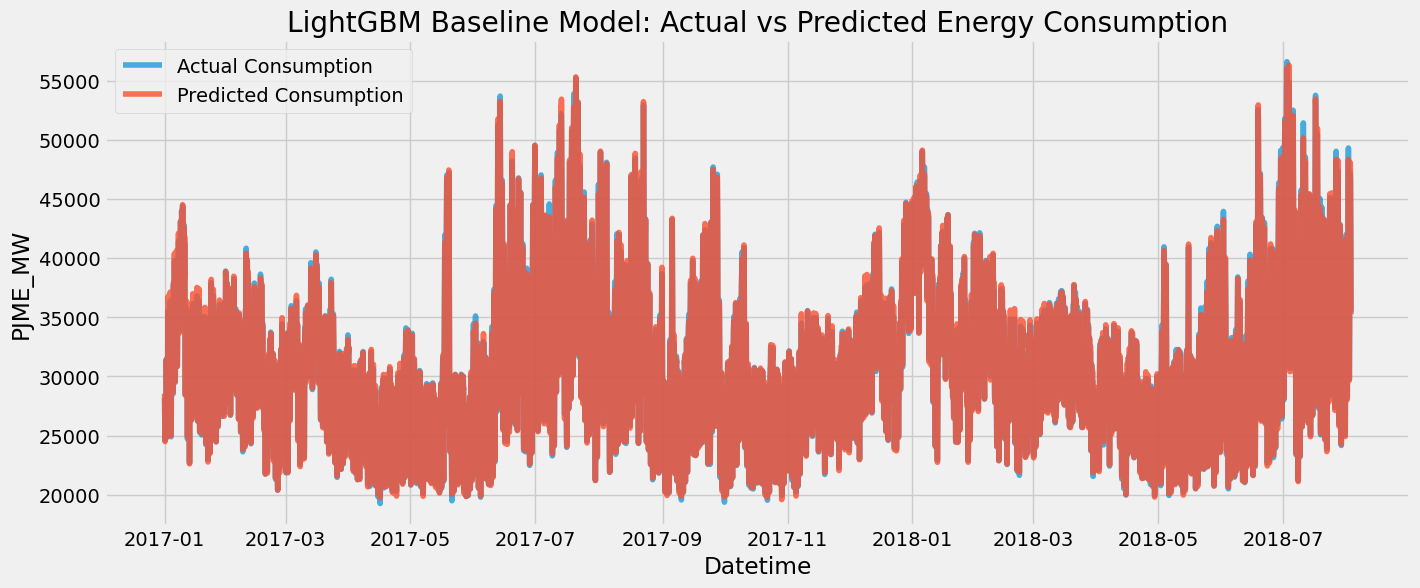

In [18]:
# --- LightGBM Model ---

# Initialise the model
# 'n_estimators' is the number of boosting rounds (trees)
lgbm_model = lgb.LGBMRegressor(
    objective='regression', # objective for regression tasks
    n_estimators=1000, # number of boosting rounds (trees)
    learning_rate=0.05, # step size shrinkage to prevent overfitting
    random_state=42, # for reproducibility
    n_jobs=-1 # to use all available CPU cores
)

# Define the early stopping callback
early_stopping_callback_lgbm = lgb.early_stopping(
    stopping_rounds=50, # number of rounds with no improvement to stop
    verbose=False # suppress printing during training
)

# Train the model
# Use eval_set and callbacks to monitor performance on a validation set
lgbm_model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)], # using X_test for validation
              eval_metric='rmse' # evaluate using Root Mean Squared Error
              )

# Make predictions on the test set
lgbm_y_pred = lgbm_model.predict(X_test)

# Evaluate the baseline model's performance
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_y_pred))
lgbm_mae = mean_absolute_error(y_test, lgbm_y_pred)
lgbm_r2 = r2_score(y_test, lgbm_y_pred)

print(f"LightGBM Baseline Model Performance:")
print(f"Root Mean Squared Error (RMSE): {lgbm_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {lgbm_mae:.2f}")
print(f"R-squared (R^2): {lgbm_r2}")

# Visualise Predictions vs Actuals
# Create a DataFrame for easy plotting
lgbm_results = pd.DataFrame({'Actual': y_test, 'Predicted': lgbm_y_pred}, index=y_test.index)

plt.figure(figsize=(15, 6))
plt.plot(lgbm_results.index, lgbm_results['Actual'], label='Actual Consumption', alpha=0.7)
plt.plot(lgbm_results.index, lgbm_results['Predicted'], label='Predicted Consumption', alpha=0.8)
plt.title('LightGBM Baseline Model: Actual vs Predicted Energy Consumption')
plt.xlabel('Datetime')
plt.ylabel('PJME_MW')
plt.legend()
plt.grid(True)
plt.show()


Top 10 Feature Importances from Baseline LightGBM Model:
                feature  importance
0           hour_of_day        4701
13           lag_1_hour        4399
1           day_of_week        1840
9              hour_sin        1781
19  rolling_72_temp_avg        1778
12        dayofyear_cos        1721
6                  year        1639
10             hour_cos        1618
14          lag_24_hour        1593
2           day_of_year        1557


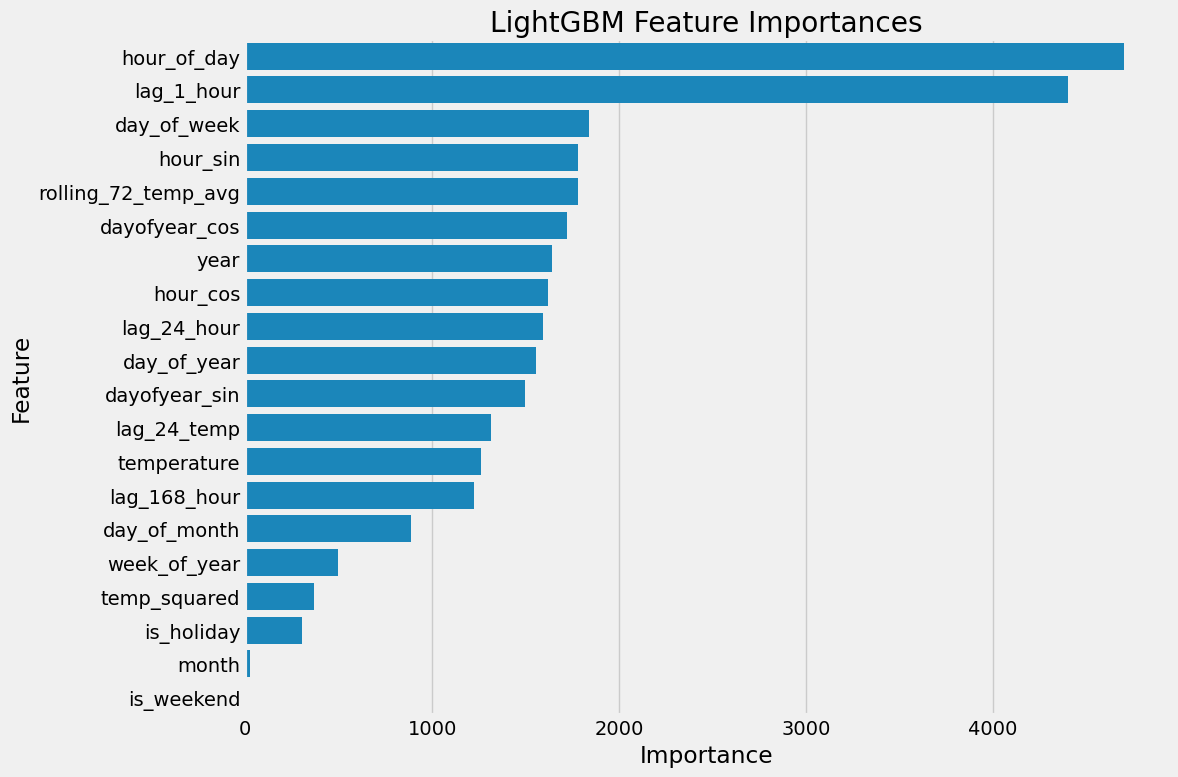

In [19]:
# Extract feature importances
lgbm_feature_importances = pd.DataFrame(
    {'feature': X_train.columns, 'importance': lgbm_model.feature_importances_}
).sort_values(by='importance', ascending=False)

print("\nTop 10 Feature Importances from Baseline LightGBM Model:")
print(lgbm_feature_importances.head(10))

# Visualise all feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=lgbm_feature_importances.head(20)) # top 20 features
plt.title('LightGBM Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()